<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from torchvision import models
import torch.nn as nn

In [2]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# プログレスバー導入
from tqdm import tqdm
import time

In [27]:
# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 店舗ごとに画像を読み込むように設定
# 標準化検討
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, score_path, transform=None):
        imgs = []
        distances = []
        scores = []
        dinner_prices = []

        # 標準化・正規化のクラスを定義
        ss_score = StandardScaler()
        ms_score = MinMaxScaler()
        ss_distance = StandardScaler()
        ms_distance = MinMaxScaler()
        ss_dinner = StandardScaler()
        ms_dinner = MinMaxScaler()

        price_list = {
            "-":0,
            "～￥999":500,
            "￥1,000～￥1,999":1500,
            "￥2,000～￥2,999":2500,
            "￥3,000～￥3,999":3500,
            "￥4,000～￥4,999":4500,
            "￥5,000～￥5,999":5500,
            "￥6,000～￥7,999":7000,
            "￥8,000～￥9,999":9000,
            "￥10,000～￥14,999":12500,
            "￥15,000～￥19,999":17500,
            "￥20,000～￥29,999":25000,
            "￥30,000～￥39,999":35000,
            "￥40,000～￥49,999":45000,
            "￥50,000～￥59,999":55000,
            "￥60,000～￥79,999":70000,
            "￥80,000～￥99,999":90000,
            "￥100,000～":120000
        }
        
        with open (score_path, 'r') as infh:
            header = next(infh)
            for line in infh:
                d = line.replace('\n', "").split("\t")
                # 画像3枚
                three_imgs = []
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[0]))
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[1]))
                three_imgs.append(os.path.join(os.path.dirname(score_path), d[2]))
                imgs.append(three_imgs)

                # 最寄りまでの距離
                distances.append(int(d[6]))

                # 夜の値段帯
                dinner_prices.append(int(price_list[d[7]]))
                
                # スコア
                if d[3] == '':
                    scores.append(float(0))
                else:
                    scores.append(float(d[3]))
        
        self.imgs = imgs

        scores = torch.from_numpy(np.array(scores)).float().view(-1, 1)
        scores = ss_score.fit_transform(scores) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        scores = ms_score.fit_transform(scores) #特徴量の最大値と最小値を計算し変換
        self.scores = torch.from_numpy(np.array(scores)).to(torch.float32).view(-1, 1)

        distances = torch.from_numpy(np.array(distances)).float().view(-1, 1)
        distances = ss_distance.fit_transform(distances) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        distances = ms_distance.fit_transform(distances) #特徴量の最大値と最小値を計算し変換
        self.distances = torch.from_numpy(np.array(distances)).to(torch.float32).view(-1, 1)

        dinner_prices = torch.from_numpy(np.array(dinner_prices)).float().view(-1, 1)
        dinner_prices = ss_dinner.fit_transform(dinner_prices) #fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
        dinner_prices = ms_dinner.fit_transform(dinner_prices) #特徴量の最大値と最小値を計算し変換
        self.dinner_prices = torch.from_numpy(np.array(dinner_prices)).to(torch.float32).view(-1, 1)
        
        self.ss_score = ss_score
        self.ms_score = ms_score
        
        self.transform = transform
        
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, i):
        img0 = PIL.Image.open(self.imgs[i][0]).convert("RGB")
        img1 = PIL.Image.open(self.imgs[i][1]).convert("RGB")
        img2 = PIL.Image.open(self.imgs[i][2]).convert("RGB")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return [img0, img1, img2, self.distances[i], self.dinner_prices[i]], self.scores[i]

In [28]:
from torchvision.transforms.transforms import Resize
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_scores_20220306211034.tsv"
full_dataset = MyDataset(data_dir, transform=transform)

# 標準化・正規化ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 標準化・正規化のクラスを定義
ss = StandardScaler()
ms = MinMaxScaler()
 
#fit_transformを用いて、特徴量の平均値と標準化を計算してから特徴量のスケール変換を行う
full_dataset.y = ss.fit_transform(full_dataset.y)

#特徴量の最大値と最小値を計算し変換
full_dataset.y = ms.fit_transform(full_dataset.y)
full_dataset.y = torch.from_numpy(full_dataset.y).to(torch.float32)

In [29]:
#　店舗ごとに分けられるように
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# # print(f"full: {len(full_dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

In [30]:
# # 1店舗(3画像)1スコアでの出力
# arch = "resnet50"
# resnet_model = models.__dict__[arch](pretrained=True)

# # 最後のfc層を削除（Identity()に変更）
# resnet_model.fc = nn.Identity()

# for p in resnet_model.parameters(): 
# #   print("p:{}\n".format(p))
#   p.requires_grad=False

In [31]:
# device設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# コードに変換可
print("各特徴量ごとの平均値は"+str(ss.mean_))
print("各特徴量ごとの標準偏差は"+str(ss.var_))

In [46]:
class CustomNet(torch.nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()

        self.imgfc1 = torch.nn.Linear(3 * 2048, 1024)
        self.imgfc2 = torch.nn.Linear(1024, 1024)
        self.imgfc3 = torch.nn.Linear(1024, 1)
        self.fc1 = torch.nn.Linear(3, 3)
        self.fc2 = torch.nn.Linear(3, 1)
        self.sigmoid = torch.nn.Sigmoid()

        # resnetの定義
        arch = "resnet50"
        resnet_model = models.__dict__[arch](pretrained=True)
        resnet_model.fc = nn.Identity()
        for p in resnet_model.parameters():
            p.requires_grad=False
        self.resnet = resnet_model.to(device)


    def imgs_features(self, imgs):
        img0 = self.resnet(imgs[0])
        img1 = self.resnet(imgs[1])
        img2 = self.resnet(imgs[2])
        imgs = torch.stack((img0, img1, img2), 1)

        imgs = imgs.view(-1, 3 * 2048) # 多次元から1次元に無理やり戻しすぎ
        imgs = self.imgfc1(imgs)
        imgs = self.imgfc2(imgs)
        imgs = self.imgfc3(imgs)
        # sigmoid関数を使って0 - 1の値に変換する
        imgs = self.sigmoid(imgs)
        return imgs
        
    def forward(self, img0, img1, img2, distance, dinner_price):
        # distance = inputs[3]
        imgs = self.imgs_features([img0, img1, img2])
        # print("distance.size(): {}, imgs.size(): {}".format(distance.size(), imgs.size()))
        outputs = torch.cat((imgs, distance, dinner_price), 1)
        # print("outputs.size(): {}".format(outputs.size()))
        # outputs = self.fc1(outputs)
        # print("outputs.size(): {}".format(outputs.size()))
        # import pdb; pdb.set_trace()
        outputs = self.fc2(outputs)
        # print("outputs.size(): {}".format(outputs.size()))

        # これいるかな、？
        outputs = self.sigmoid(outputs)
        
        return outputs

custom_model = CustomNet()
custom_model = custom_model.to(device)

# test
resnet_model.train()

data = next(iter(train_loader))
img0, img1, img2, scores = data
scores /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
scores = scores.to(device)
# optimizer.zero_grad()
output0 = resnet_model(img0)
output1 = resnet_model(img1)
output2 = resnet_model(img2)
torch.stack((output0, output1, output2), 1).size()

In [44]:
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

criterion = RMSELoss()


In [60]:
# train_loss = []
# valid_loss = []
# valid_scores = torch.tensor([]).to(device)
# valid_outputs = torch.tensor([]).to(device)

# for epoch in tqdm(range(50)):
#   # 学習
# #  そもそも勾配変化がしないのでなしでいい
# #   resnet_model.train()
#   custom_model.train()
#   running_train_loss = 0.0
#   with torch.set_grad_enabled(True):
#     for data in train_loader:
#       # custom_modelに入れ込む↓
#       img0, img1, img2, scores = data
#       img0 = img0.to(device)
#       img1 = img1.to(device)
#       img2 = img2.to(device)
#       scores = scores.to(device)
#       output0 = resnet_model(img0)
#       output1 = resnet_model(img1)
#       output2 = resnet_model(img2)
#       outputs = torch.stack((output0, output1, output2), 1)
      
#       outputs = custom_model(outputs)
#       # torch.Size([64, 3, 2048])
#       loss = criterion(outputs, scores)
#     #   print("loss.item():{}\n".format(loss.item()))
#       running_train_loss += loss.item()
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#     #   print(outputs)

#   train_loss.append(running_train_loss / len(train_dataset))
  
#   # 検証
# #   resnet_model.eval()
#   custom_model.eval()
#   running_valid_loss = 0.0
#   with torch.set_grad_enabled(False):
#     for data in valid_loader:

#       img0, img1, img2, scores = data
#       img0 = img0.to(device)
#       img1 = img1.to(device)
#       img2 = img2.to(device)
#       scores = scores.to(device)
#       output0 = resnet_model(img0)
#       output1 = resnet_model(img1)
#       output2 = resnet_model(img2)
#       outputs = torch.stack((output0, output1, output2), 1)
#       outputs = custom_model(outputs)
#       # print("loss.item():{}\n".format(loss.item()))
#       running_valid_loss += loss.item()
#       valid_outputs = torch.cat((valid_outputs, outputs), 0)
#       valid_scores = torch.cat((valid_scores, scores), 0)


#   valid_loss.append(running_valid_loss / len(valid_dataset))
# #   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
#   print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
#                                                 running_train_loss / len(train_loss), 
#                                                 running_valid_loss / len(valid_loss)))

In [47]:
train_loss = []
valid_loss = []
valid_outputs = torch.tensor([]).to(device)
valid_scores = torch.tensor([]).to(device)

for epoch in tqdm(range(50)):
  # 学習
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      inputs, scores = data
      scores = scores.to(device)
      for i in range(len(inputs)):
          inputs[i] = inputs[i].to(device)
    #   inputs = inputs.to(device)
      outputs = custom_model(inputs[0], inputs[1], inputs[2], inputs[3], inputs[4])
      # torch.Size([64, 3, 2048])
      loss = criterion(outputs, scores)
    #   print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:
      inputs, scores = data
      scores = scores.to(device)
      for i in range(len(inputs)):
          inputs[i] = inputs[i].to(device)
      outputs = custom_model(inputs[0], inputs[1], inputs[2], inputs[3], inputs[4])
      # print("loss.item():{}\n".format(loss.item()))
      running_valid_loss += loss.item()
      valid_outputs = torch.cat((valid_outputs, outputs), 0)
      valid_scores = torch.cat((valid_scores, scores), 0)


  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

  2%|▏         | 1/50 [00:15<12:38, 15.49s/it]

#epoch:0	train loss: 3.3019504100084305	valid loss: 1.0187886953353882


  4%|▍         | 2/50 [00:30<12:14, 15.30s/it]

#epoch:1	train loss: 1.6415218338370323	valid loss: 0.4259505271911621


  6%|▌         | 3/50 [00:46<12:04, 15.42s/it]

#epoch:2	train loss: 1.0954389373461406	valid loss: 0.29581371943155926


  8%|▊         | 4/50 [01:01<11:49, 15.43s/it]

#epoch:3	train loss: 0.8233811967074871	valid loss: 0.2425500899553299


 10%|█         | 5/50 [01:17<11:33, 15.42s/it]

#epoch:4	train loss: 0.6570615917444229	valid loss: 0.17978496551513673


 12%|█▏        | 6/50 [01:32<11:21, 15.50s/it]

#epoch:5	train loss: 0.5498916034897169	valid loss: 0.1698052485783895


 14%|█▍        | 7/50 [01:48<11:08, 15.54s/it]

#epoch:6	train loss: 0.4706907080752509	valid loss: 0.1363837378365653


 16%|█▌        | 8/50 [02:03<10:48, 15.45s/it]

#epoch:7	train loss: 0.41411539167165756	valid loss: 0.13656707108020782


 18%|█▊        | 9/50 [02:19<10:32, 15.44s/it]

#epoch:8	train loss: 0.36512498060862225	valid loss: 0.10092188914616902


 20%|██        | 10/50 [02:34<10:18, 15.47s/it]

#epoch:9	train loss: 0.3286741688847542	valid loss: 0.08881615996360778


 22%|██▏       | 11/50 [02:49<10:03, 15.46s/it]

#epoch:10	train loss: 0.3008353534069928	valid loss: 0.09764797037298029


 24%|██▍       | 12/50 [03:05<09:43, 15.37s/it]

#epoch:11	train loss: 0.27594760184486705	valid loss: 0.09035071730613708


 26%|██▌       | 13/50 [03:20<09:28, 15.36s/it]

#epoch:12	train loss: 0.2547942709464293	valid loss: 0.08663873489086445


 28%|██▊       | 14/50 [03:36<09:16, 15.45s/it]

#epoch:13	train loss: 0.23570040400539125	valid loss: 0.07220797027860369


 30%|███       | 15/50 [03:51<08:59, 15.40s/it]

#epoch:14	train loss: 0.22124245862166086	valid loss: 0.07706095377604166


 32%|███▏      | 16/50 [04:06<08:45, 15.45s/it]

#epoch:15	train loss: 0.20703569892793894	valid loss: 0.06940315663814545


 34%|███▍      | 17/50 [04:22<08:31, 15.49s/it]

#epoch:16	train loss: 0.19455931204206803	valid loss: 0.06157510420855354


 36%|███▌      | 18/50 [04:37<08:13, 15.42s/it]

#epoch:17	train loss: 0.18348537551032174	valid loss: 0.05873366859224108


 38%|███▊      | 19/50 [04:53<07:58, 15.45s/it]

#epoch:18	train loss: 0.17374123476053538	valid loss: 0.056124982080961526


 40%|████      | 20/50 [05:08<07:43, 15.44s/it]

#epoch:19	train loss: 0.16502681821584703	valid loss: 0.05195739269256592


 42%|████▏     | 21/50 [05:24<07:30, 15.52s/it]

#epoch:20	train loss: 0.1575676408551988	valid loss: 0.050772848583403085


 44%|████▍     | 22/50 [05:40<07:15, 15.54s/it]

#epoch:21	train loss: 0.15019630234349857	valid loss: 0.047199823639609596


 46%|████▌     | 23/50 [05:55<06:57, 15.48s/it]

#epoch:22	train loss: 0.14403707631256268	valid loss: 0.04760399072066597


 48%|████▊     | 24/50 [06:11<06:44, 15.55s/it]

#epoch:23	train loss: 0.13724478768805662	valid loss: 0.04129608472188314


 50%|█████     | 25/50 [06:26<06:27, 15.49s/it]

#epoch:24	train loss: 0.13259699881076814	valid loss: 0.045100951194763185


 52%|█████▏    | 26/50 [06:41<06:11, 15.50s/it]

#epoch:25	train loss: 0.12590986089064524	valid loss: 0.030643105506896973


 54%|█████▍    | 27/50 [06:57<05:56, 15.51s/it]

#epoch:26	train loss: 0.1227477154246083	valid loss: 0.04127551449669732


 56%|█████▌    | 28/50 [07:12<05:39, 15.42s/it]

#epoch:27	train loss: 0.11791209663663592	valid loss: 0.03589185220854623


 58%|█████▊    | 29/50 [07:28<05:23, 15.41s/it]

#epoch:28	train loss: 0.11407006403495526	valid loss: 0.037478089332580566


 60%|██████    | 30/50 [07:43<05:08, 15.42s/it]

#epoch:29	train loss: 0.11006468037764232	valid loss: 0.03433235883712769


 62%|██████▏   | 31/50 [07:58<04:52, 15.40s/it]

#epoch:30	train loss: 0.10687118672555493	valid loss: 0.03567760605965891


 64%|██████▍   | 32/50 [08:14<04:38, 15.45s/it]

#epoch:31	train loss: 0.10266969352960587	valid loss: 0.027401939034461975


 66%|██████▌   | 33/50 [08:29<04:21, 15.40s/it]

#epoch:32	train loss: 0.10009943490678613	valid loss: 0.030555977965846207


 68%|██████▊   | 34/50 [08:45<04:06, 15.39s/it]

#epoch:33	train loss: 0.09693661375957377	valid loss: 0.029709886102115408


 70%|███████   | 35/50 [09:00<03:50, 15.39s/it]

#epoch:34	train loss: 0.09356782351221357	valid loss: 0.02278717075075422


 72%|███████▏  | 36/50 [09:16<03:36, 15.43s/it]

#epoch:35	train loss: 0.09177488833665848	valid loss: 0.0288656751314799


 74%|███████▍  | 37/50 [09:31<03:20, 15.45s/it]

#epoch:36	train loss: 0.08940034782564318	valid loss: 0.029019081914747082


 76%|███████▌  | 38/50 [09:46<03:04, 15.40s/it]

#epoch:37	train loss: 0.08676000253150337	valid loss: 0.026583423739985415


 78%|███████▊  | 39/50 [10:02<02:49, 15.38s/it]

#epoch:38	train loss: 0.08490277941410358	valid loss: 0.02839190837664482


 80%|████████  | 40/50 [10:17<02:33, 15.39s/it]

#epoch:39	train loss: 0.08247291035950184	valid loss: 0.024311698973178864


 82%|████████▏ | 41/50 [10:33<02:19, 15.45s/it]

#epoch:40	train loss: 0.08052627342503245	valid loss: 0.025924964648921314


 84%|████████▍ | 42/50 [10:48<02:02, 15.36s/it]

#epoch:41	train loss: 0.07892393782025292	valid loss: 0.027508704435257686


 86%|████████▌ | 43/50 [11:03<01:47, 15.38s/it]

#epoch:42	train loss: 0.07663529002389242	valid loss: 0.022696522779242938


 88%|████████▊ | 44/50 [11:18<01:31, 15.31s/it]

#epoch:43	train loss: 0.07527342201633887	valid loss: 0.024424154650081287


 90%|█████████ | 45/50 [11:34<01:16, 15.29s/it]

#epoch:44	train loss: 0.0736312233739429	valid loss: 0.024678177303738065


 92%|█████████▏| 46/50 [11:49<01:01, 15.30s/it]

#epoch:45	train loss: 0.07200003091407858	valid loss: 0.02414753126061481


 94%|█████████▍| 47/50 [12:04<00:46, 15.37s/it]

#epoch:46	train loss: 0.07027033351837321	valid loss: 0.021444292778664446


 96%|█████████▌| 48/50 [12:20<00:30, 15.37s/it]

#epoch:47	train loss: 0.06877522605160873	valid loss: 0.021526843309402466


 98%|█████████▊| 49/50 [12:35<00:15, 15.35s/it]

#epoch:48	train loss: 0.06750604540717844	valid loss: 0.022036095054782167


100%|██████████| 50/50 [12:51<00:00, 15.43s/it]

#epoch:49	train loss: 0.06594640463590622	valid loss: 0.019649527072906493


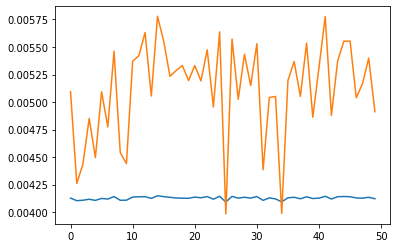

In [66]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

In [42]:
valid_outputs.size()
valid_scores.size()

torch.Size([10000, 1])

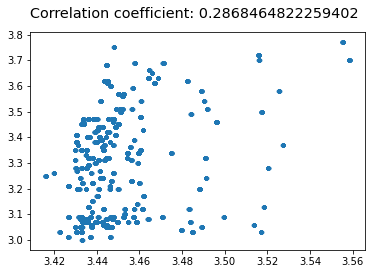

In [70]:
fig = plt.figure()
ax = fig.add_subplot()

# 標準化・正規化を戻す
ss = full_dataset.ss_score
ms = full_dataset.ms_score
plot_outputs = ss.inverse_transform(ms.inverse_transform(valid_outputs.cpu().detach().numpy()))
plot_scores = ss.inverse_transform(ms.inverse_transform(valid_scores.cpu().detach().numpy()))

from itertools import chain
# 相関行列を計算
coef = np.corrcoef(list(chain.from_iterable(plot_outputs)), list(chain.from_iterable(plot_scores)))
# print(plot_outputs)
# fig内でのaxes座標を取得，戻り値はBbox
ax_pos = ax.get_position()
coef_text = "Correlation coefficient: " + str(coef[0][1])
# fig内座標でテキストを表示 Bboxは Bbox.x0, Bbox.x1, Bbox.y0, Bbox.y1で座標を取得できる
fig.text(ax_pos.x0, ax_pos.y1 + 0.05, coef_text, fontsize='x-large')  

ax.scatter(plot_outputs, plot_scores, s=8)
fig.show()

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224

In [ ]:
class RegressionNet(torch.nn.Module):
    
    def __init__(self):
        super(RegressionNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 78 * 78, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # x = torch.nn.functional.relu(self.conv1(x))
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])
        x = self.conv1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.pool1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 159, 159])
        # x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.pool2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 78, 78])

        x = x.view(-1, 32 * 78 * 78) # 多次元から1次元に無理やり戻しすぎ
        x = self.relu(x) # 別の活性化関数に変更（tanhなど）
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print("x:{}".format(x))
        # sigmoid関数を使って0 - 1の値に変換する
        
        return x

In [ ]:
# 1画像1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

In [ ]:
# test
resnet_model.train()

data = next(iter(train_loader))
img0, img1, img2, scores = data
scores /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
scores = scores.to(device)
# optimizer.zero_grad()
outputs = resnet_model(img0)
outputs.size()

torch.Size([64, 2048])